In [1]:
# Force garbage collection to release file handles
import gc
gc.collect()

# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime

# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.optim as optim

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft


# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)
current_dir = os.getcwd()



Using Device: cuda
Using PyTorch version: 2.5.1


In [2]:
def load_and_process_dataset(data_path, print_dataset=True):
    start_time = time.time()
    (designs, design_params, n_designs, n_panes, design_res,
     WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors,
     EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x,
     EIGENVECTOR_DATA_y, const, N_struct,
     imag_tol, rng_seed_offset) = NO_utils.extract_data(data_path)

    print(f"Loading dataset path: {data_path}")
    # Take first pane of designs
    designs = designs[:,0,:,:]

    # Convert WAVEVECTOR_DATA to spatial domain
    WAVEFORM_DATA = NO_utils_multiple.embed_2const_wavelet(WAVEVECTOR_DATA[0,:,0], WAVEVECTOR_DATA[0,:,1], size=design_res) #(600, 325, 2)

    # Convert all bands to spatial domain
    bands = np.arange(1, n_bands + 1)
    bands_fft = NO_utils_multiple.embed_integer_wavelet(bands, size=design_res)

    # Create the result dictionary
    dataset = {
        "designs": designs, "design_params": design_params, "n_designs": n_designs,
        "WAVEVECTOR_DATA": WAVEVECTOR_DATA, "WAVEFORM_DATA": WAVEFORM_DATA,
        "EIGENVALUE_DATA": EIGENVALUE_DATA, "EIGENVECTOR_DATA_x": EIGENVECTOR_DATA_x,
        "EIGENVECTOR_DATA_y": EIGENVECTOR_DATA_y, "bands_fft": bands_fft
    }
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print dataset sizes and elapsed time
    if print_dataset:
        print(f"Dataset loaded from {data_path}:")
        for key, value in dataset.items():
            print(f"  {key}: {np.shape(value)}")
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return dataset

def save_dataset(save_path, designs=None, design_params=None, waveforms=None, wavevectors=None, 
                eigenvalue_data=None, eigenvector_data_x=None, eigenvector_data_y=None, bands_fft=None):
    """
    Save dataset arrays to a specified path.
    
    Parameters:
    - save_path: Path to save the dataset
    - designs: Array of design patterns (optional)
    - design_params: Array of design parameters (optional)
    - waveforms: Array of waveform data (optional)
    - wavevectors: Array of wavevector data (optional)
    - eigenvalue_data: Array of eigenvalues (optional)
    - eigenvector_data_x: Array of x-component eigenvectors (optional)
    - eigenvector_data_y: Array of y-component eigenvectors (optional)
    - bands_fft: Array of band data in Fourier space (optional)
    """
    os.makedirs(save_path, exist_ok=True)
    
    print(f"Dataset saved to {save_path}")
    
    # Save each array with np.save if provided
    if designs is not None:
        np.save(os.path.join(save_path, 'designs.npy'), designs.astype(np.float16))
        saved_arrays = ['designs']
    if design_params is not None:
        np.save(os.path.join(save_path, 'design_params.npy'), design_params.astype(np.float64))
        saved_arrays.append('design_params')
    if waveforms is not None:
        np.save(os.path.join(save_path, 'waveforms.npy'), waveforms.astype(np.float16))
        saved_arrays.append('waveforms')
    if wavevectors is not None:
        np.save(os.path.join(save_path, 'wavevectors.npy'), wavevectors.astype(np.float16))
        saved_arrays.append('wavevectors')
    if eigenvalue_data is not None:
        np.save(os.path.join(save_path, 'eigenvalue_data.npy'), eigenvalue_data)
        saved_arrays.append('eigenvalue_data')
    if eigenvector_data_x is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_x.npy'), eigenvector_data_x)
        saved_arrays.append('eigenvector_data_x')
    if eigenvector_data_y is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_y.npy'), eigenvector_data_y)
        saved_arrays.append('eigenvector_data_y')
    if bands_fft is not None:
        np.save(os.path.join(save_path, 'bands_fft.npy'), bands_fft.astype(np.float16))
        saved_arrays.append('bands_fft')
    
    print(f"Saved arrays: {', '.join(saved_arrays)}")

def load_dataset(load_path, drop_redundant=True):
    """
    Load dataset arrays from a specified path.
    
    Parameters:
    - load_path: Path to load the dataset from
    
    Returns:
    - designs: Array of design patterns
    - design_params: Array of design parameters
    - waveforms: Array of waveform data
    - wavevectors: Array of wavevector data
    - eigenvalue_data: Array of eigenvalues
    - eigenvector_data_x: Array of x-component eigenvectors
    - eigenvector_data_y: Array of y-component eigenvectors
    - bands_fft: Array of band data in Fourier space
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Dataset directory {load_path} does not exist")
    
    # Load each array with np.load
    if drop_redundant:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    else:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    design_params = np.load(os.path.join(load_path, 'design_params.npy'))
    eigenvalue_data = np.load(os.path.join(load_path, 'eigenvalue_data.npy'))
    eigenvector_data_x = np.load(os.path.join(load_path, 'eigenvector_data_x.npy'))
    eigenvector_data_y = np.load(os.path.join(load_path, 'eigenvector_data_y.npy'))
    bands_fft = np.load(os.path.join(load_path, 'bands_fft.npy'))
    
    print(f"Dataset loaded from {load_path}")
    
    return designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft

def convert_dataset_to_float16(input_folder, output_folder):
    """
    Convert dataset from input folder to float16 and save to output folder.
    
    Args:
        input_folder (str): Name of the input folder (e.g., 'set 1')
        output_folder (str): Name of the output folder (e.g., 'set 1 f16')
    """
    # Construct full paths
    input_path = os.path.join(current_dir, 'data', input_folder)
    output_path = os.path.join(current_dir, 'data', output_folder)
    
    print(f"Loading data from {input_path}...")
    
    # Load the data
    designs = np.load(os.path.join(input_path, "designs.npy"))
    design_params = np.load(os.path.join(input_path, "design_params.npy"))
    waveforms = np.load(os.path.join(input_path, "waveforms.npy"))
    wavevectors = np.load(os.path.join(input_path, "wavevectors.npy"))
    eigenvalue_data = np.load(os.path.join(input_path, "eigenvalue_data.npy"))
    eigenvector_data_x = np.load(os.path.join(input_path, "eigenvector_data_x.npy"))
    eigenvector_data_y = np.load(os.path.join(input_path, "eigenvector_data_y.npy"))
    bands_fft = np.load(os.path.join(input_path, "bands_fft.npy"))
    
    print("Data loaded successfully!")
    print(f"designs shape: {designs.shape}, dtype: {designs.dtype}")
    print(f"design_params shape: {design_params.shape}, dtype: {design_params.dtype}")
    print(f"waveforms shape: {waveforms.shape}, dtype: {waveforms.dtype}")
    print(f"wavevectors shape: {wavevectors.shape}, dtype: {wavevectors.dtype}")
    print(f"eigenvalue_data shape: {eigenvalue_data.shape}, dtype: {eigenvalue_data.dtype}")
    print(f"eigenvector_data_x shape: {eigenvector_data_x.shape}, dtype: {eigenvector_data_x.dtype}")
    print(f"eigenvector_data_y shape: {eigenvector_data_y.shape}, dtype: {eigenvector_data_y.dtype}")
    print(f"bands_fft shape: {bands_fft.shape}, dtype: {bands_fft.dtype}")
    
    print("\nConverting data to float16...")
    
    # Convert to float16
    designs = designs.astype(np.float16)
    waveforms = waveforms.astype(np.float16)
    bands_fft = bands_fft.astype(np.float16)
    
    # For eigenvector data, separate real and imaginary components and convert to float16
    eigenvector_data_x_real = np.real(eigenvector_data_x).astype(np.float16)
    eigenvector_data_x_imag = np.imag(eigenvector_data_x).astype(np.float16)
    eigenvector_data_y_real = np.real(eigenvector_data_y).astype(np.float16)
    eigenvector_data_y_imag = np.imag(eigenvector_data_y).astype(np.float16)
    
    print("Data conversion to float16 completed.")
    print(f"designs new dtype: {designs.dtype}, shape: {designs.shape}")
    print(f"waveforms new dtype: {waveforms.dtype}, shape: {waveforms.shape}")
    print(f"bands_fft new dtype: {bands_fft.dtype}, shape: {bands_fft.shape}")
    print(f"eigenvector_data_x_real dtype: {eigenvector_data_x_real.dtype}, shape: {eigenvector_data_x_real.shape}")
    print(f"eigenvector_data_x_imag dtype: {eigenvector_data_x_imag.dtype}, shape: {eigenvector_data_x_imag.shape}")
    print(f"eigenvector_data_y_real dtype: {eigenvector_data_y_real.dtype}, shape: {eigenvector_data_y_real.shape}")
    print(f"eigenvector_data_y_imag dtype: {eigenvector_data_y_imag.dtype}, shape: {eigenvector_data_y_imag.shape}")
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    print(f"\nSaving converted data to {output_path}...")
    
    # Save the converted arrays
    np.save(os.path.join(output_path, "designs.npy"), designs)
    np.save(os.path.join(output_path, "design_params.npy"), design_params)
    np.save(os.path.join(output_path, "waveforms.npy"), waveforms)
    np.save(os.path.join(output_path, "wavevectors.npy"), wavevectors)
    np.save(os.path.join(output_path, "eigenvalue_data.npy"), eigenvalue_data)
    np.save(os.path.join(output_path, "eigenvector_data_x_real.npy"), eigenvector_data_x_real)
    np.save(os.path.join(output_path, "eigenvector_data_x_imag.npy"), eigenvector_data_x_imag)
    np.save(os.path.join(output_path, "eigenvector_data_y_real.npy"), eigenvector_data_y_real)
    np.save(os.path.join(output_path, "eigenvector_data_y_imag.npy"), eigenvector_data_y_imag)
    np.save(os.path.join(output_path, "bands_fft.npy"), bands_fft)
    
    print("Data saved successfully!")
    print(f"Files saved in {output_path}:")
    for filename in os.listdir(output_path):
        if filename.endswith('.npy'):
            print(f"  - {filename}")
    
    return designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x_real, eigenvector_data_x_imag, eigenvector_data_y_real, eigenvector_data_y_imag, bands_fft

In [3]:
# Load and print out .mat contents
data_paths = [
    # os.path.join(current_dir, 'data', 'set_c1_1200n'),
    # os.path.join(current_dir, 'data', 'set_c2_1200n'),
    # os.path.join(current_dir, 'data', 'set_c3_1200n'),
    # os.path.join(current_dir, 'data', 'set_c4_1200n'),
    # os.path.join(current_dir, 'data', 'set_c5_1200n'),
    # os.path.join(current_dir, 'data', 'set_c6_1200n'),
    # os.path.join(current_dir, 'data', 'set_c7_1200n'),
    # os.path.join(current_dir, 'data', 'set_c8_1200n'),
    # os.path.join(current_dir, 'data', 'set_c9_1200n'),
    # os.path.join(current_dir, 'data', 'set_c10_1200n'),
    # os.path.join(current_dir, 'data', 'set_c11_1200n'),
    # os.path.join(current_dir, 'data', 'set_c12_1200n'),
    # os.path.join(current_dir, 'data', 'set_c13_1200n'),
    # os.path.join(current_dir, 'data', 'set_c14_1200n'),
    # os.path.join(current_dir, 'data', 'set_c15_1200n'),
    # os.path.join(current_dir, 'data', 'set_c16_1200n'),
    # os.path.join(current_dir, 'data', 'set_c17_1200n'),
    # os.path.join(current_dir, 'data', 'set_c18_1200n'),
    # os.path.join(current_dir, 'data', 'set_c19_1200n'),
    # os.path.join(current_dir, 'data', 'set_c20_1200n'),
    # os.path.join(current_dir, 'data', 'set_cr_1200n'),
    # os.path.join(current_dir, 'data', 'set_b1_1200n'),
    # os.path.join(current_dir, 'data', 'set_b2_1200n'),
    # os.path.join(current_dir, 'data', 'set_b3_1200n'),
    # os.path.join(current_dir, 'data', 'set_b4_1200n'),
    # os.path.join(current_dir, 'data', 'set_b5_1200n'),
    # os.path.join(current_dir, 'data', 'set_b6_1200n'),
    # os.path.join(current_dir, 'data', 'set_b7_1200n'),
    # os.path.join(current_dir, 'data', 'set_b8_1200n'),
    # os.path.join(current_dir, 'data', 'set_b9_1200n'),
    # os.path.join(current_dir, 'data', 'set_b10_1200n'),
    # os.path.join(current_dir, 'data', 'set_b11_1200n'),
    # os.path.join(current_dir, 'data', 'set_b12_1200n'),
    # os.path.join(current_dir, 'data', 'set_b13_1200n'),
    # os.path.join(current_dir, 'data', 'set_b14_1200n'),
    # os.path.join(current_dir, 'data', 'set_b15_1200n'),
    # os.path.join(current_dir, 'data', 'set_b16_1200n'),
    # os.path.join(current_dir, 'data', 'set_b17_1200n'),
    # os.path.join(current_dir, 'data', 'set_b18_1200n'),
    # os.path.join(current_dir, 'data', 'set_b19_1200n'),
    # os.path.join(current_dir, 'data', 'set_b20_1200n'),
    # os.path.join(current_dir, 'data', 'set_br_1200n'),
]

for data_path in data_paths:
    print('Loading dataset:', data_path)
    # Load and print out .mat contents
    data = load_and_process_dataset(data_path)
    try:
        print(f"designs shape: {data['designs'].shape}, dtype: {data['designs'].dtype}")
        print(f"design_params shape: {data['design_params'].shape}, dtype: {data['design_params'].dtype}")
        print(f"n_designs shape: {data['n_designs']}, dtype: {data['n_designs'].dtype}")
        print(f"WAVEVECTOR_DATA shape: {data['WAVEVECTOR_DATA'].shape}, dtype: {data['WAVEVECTOR_DATA'].dtype}")
        print(f"WAVEFORM_DATA shape: {data['WAVEFORM_DATA'].shape}, dtype: {data['WAVEFORM_DATA'].dtype}")
        print(f"EIGENVALUE_DATA shape: {data['EIGENVALUE_DATA'].shape}, dtype: {data['EIGENVALUE_DATA'].dtype}")
        print(f"EIGENVECTOR_DATA_x shape: {data['EIGENVECTOR_DATA_x'].shape}, dtype: {data['EIGENVECTOR_DATA_x'].dtype}")
        print(f"EIGENVECTOR_DATA_y shape: {data['EIGENVECTOR_DATA_y'].shape}, dtype: {data['EIGENVECTOR_DATA_y'].dtype}")
        print(f"bands_fft shape: {data['bands_fft'].shape}, dtype: {data['bands_fft'].dtype}")
    except Exception as e:
        print(f"Error printing data shapes: {e}")

    # Save the dataset in the same folder
    save_dataset(data_path, data['designs'], 
                    data['design_params'], 
                    data['WAVEFORM_DATA'], 
                    data['WAVEVECTOR_DATA'], 
                    data['EIGENVALUE_DATA'], 
                    data['EIGENVECTOR_DATA_x'], 
                    data['EIGENVECTOR_DATA_y'], 
                    data['bands_fft'])

    # Delete the dataset to free up memory
    del data

## Make reduced datasets from converted datasets

In [4]:
def reduce_dataset(input_folder, output_folder, WVR=0.2, BR=0.5, DO=0, use_e4m3=False):
    """
    Reduce a dataset by selecting specific wavevectors and bands, then save the reduced dataset.
    
    Parameters:
    - input_folder: Path to the input dataset folder
    - output_folder: Path to save the reduced dataset
    - WVR: Wavevector reduction ratio for random selection (e.g., 0.2 means keep 20% of wavevectors)
    - BR: Band reduction ratio for random selection (e.g., 0.5 means keep 50% of bands)
    - DO: Dataset offset (adds DO to geometry index)
    - use_e4m3: If True, save tensors in torch e4m3 format for reduced precision
    """
    
    # Construct full paths
    input_path = os.path.join(current_dir, 'data', input_folder)
    output_path = os.path.join(current_dir, 'data', output_folder)
    
    print(f"Loading data from {input_path}...")

    # Load data from input folder
    designs = np.load(os.path.join(input_path, "designs.npy"))
    waveforms = np.load(os.path.join(input_path, "waveforms.npy"))
    wavevectors = np.load(os.path.join(input_path, "wavevectors.npy"))
    bands_fft = np.load(os.path.join(input_path, "bands_fft.npy"))
    design_params = np.load(os.path.join(input_path, "design_params.npy"))
    eigenvector_data_x = np.load(os.path.join(input_path, "eigenvector_data_x.npy"))
    eigenvector_data_y = np.load(os.path.join(input_path, "eigenvector_data_y.npy"))
    
    print(f"Original data shapes:")
    print(f"Designs: {designs.shape}")
    print(f"Waveforms: {waveforms.shape}")
    print(f"Wavevectors: {wavevectors.shape}")
    print(f"Bands FFT: {bands_fft.shape}")
    print(f"Design params: {design_params.shape}")
    print(f"Eigenvector x: {eigenvector_data_x.shape}")
    print(f"Eigenvector y: {eigenvector_data_y.shape}")
    
    # Apply dataset offset to geometry indices
    if DO != 0:
        print(f"Applying dataset offset: {DO} (adding {DO} to geometry indices)")
        # Assuming first column is geometry index
        design_params[:, 0] += DO
    
    waveforms_reduced_amount = int(waveforms.shape[0] * WVR)
    bands_fft_reduced_amount = int(bands_fft.shape[0] * BR)
    samples_reduced_amount = int(designs.shape[0] * waveforms_reduced_amount * bands_fft_reduced_amount)
    reduced_indices_reserved = [None] * samples_reduced_amount
    print(f"Waveforms reduced amount: {waveforms_reduced_amount}")
    print(f"Bands FFT reduced amount: {bands_fft_reduced_amount}")
    # Track the current index for insertion
    current_idx = 0

    # For each design, select random subsets of waveforms and bands
    for d_idx in range(designs.shape[0]):
        # Get random waveform indices (0 to 324)
        waveform_indices = np.random.choice(waveforms.shape[0], size=waveforms_reduced_amount, replace=False)
        
        for w_idx in waveform_indices:
            # Get random band indices (0 to 5) 
            band_indices = np.random.choice(bands_fft.shape[0], size=bands_fft_reduced_amount, replace=False)
            
            # Add index tuples for this design's samples
            for b_idx in band_indices:
                reduced_indices_reserved[current_idx] = (d_idx, w_idx, b_idx)
                current_idx += 1
    
    single_image_size = eigenvector_data_x.shape[-1]**2
    print(f"Total reduced indices: {len(reduced_indices_reserved)}")
    print(f"Original total elements: {eigenvector_data_x.size / single_image_size}")
    print(f"Reduction ratio: {eigenvector_data_x.size / single_image_size / len(reduced_indices_reserved):.2f}")
    
    # Extract reduced data using the indices
    eigenvector_data_x_reduced = eigenvector_data_x[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    eigenvector_data_y_reduced = eigenvector_data_y[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    print(f"Reduced eigenvector x shape: {eigenvector_data_x_reduced.shape}")
    print(f"Reduced eigenvector y shape: {eigenvector_data_y_reduced.shape}")
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Convert to torch tensors with optional e4m3 format
    if use_e4m3:
        print("Converting to e4m3 format...")
        # For complex data, we need to handle real and imaginary parts separately
        eigenvector_x_real_tensor = torch.from_numpy(eigenvector_data_x_reduced.real).to(torch.float8_e4m3fn)
        eigenvector_x_imag_tensor = torch.from_numpy(eigenvector_data_x_reduced.imag).to(torch.float8_e4m3fn)
        eigenvector_y_real_tensor = torch.from_numpy(eigenvector_data_y_reduced.real).to(torch.float8_e4m3fn)
        eigenvector_y_imag_tensor = torch.from_numpy(eigenvector_data_y_reduced.imag).to(torch.float8_e4m3fn)
    else:
        eigenvector_x_real_tensor = torch.from_numpy(eigenvector_data_x_reduced.real)
        eigenvector_x_imag_tensor = torch.from_numpy(eigenvector_data_x_reduced.imag)
        eigenvector_y_real_tensor = torch.from_numpy(eigenvector_data_y_reduced.real)
        eigenvector_y_imag_tensor = torch.from_numpy(eigenvector_data_y_reduced.imag)
    
    # Create and save reduced dataset
    reduced_data = torch.utils.data.TensorDataset(
        eigenvector_x_real_tensor,
        eigenvector_x_imag_tensor,
        eigenvector_y_real_tensor,
        eigenvector_y_imag_tensor
    )
    
    # Save dataset components as separate files
    torch.save(reduced_data, os.path.join(output_path, "displacements_dataset.pt"))
    torch.save(reduced_indices_reserved, os.path.join(output_path, "reduced_indices.pt"))
    torch.save(torch.from_numpy(designs), os.path.join(output_path, "geometries_full.pt"))
    torch.save(torch.from_numpy(waveforms), os.path.join(output_path, "waveforms_full.pt"))
    torch.save(torch.from_numpy(wavevectors), os.path.join(output_path, "wavevectors_full.pt"))
    torch.save(torch.from_numpy(bands_fft), os.path.join(output_path, "band_fft_full.pt"))
    
    # Handle potential NaN values in design_params before converting to int64
    design_params_clean = design_params.copy()
    if np.any(np.isnan(design_params_clean)):
        print("Warning: NaN values found in design_params, replacing with 0")
        design_params_clean = np.nan_to_num(design_params_clean, nan=0)
    
    torch.save(torch.from_numpy(design_params_clean.astype(np.int64)), os.path.join(output_path, "design_params_full.pt"))
    
    print(f"Reduced dataset saved to: {output_path}")
    print(f"Using e4m3 format: {use_e4m3}")
    
    return {
        'tensor_dataset': reduced_data,
        'reduced_indices': reduced_indices_reserved,
        'geometries_full': torch.from_numpy(designs),
        'waveforms_full': torch.from_numpy(waveforms),
        'wavevectors_full': torch.from_numpy(wavevectors),
        'band_fft_full': torch.from_numpy(bands_fft),
        'design_params_full': torch.from_numpy(design_params_clean.astype(np.int64)),
    }

In [7]:
# Reduce the continuous datasets with float16
# _ = reduce_dataset('set_c1_1200n', 'set_c1_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(1-1), use_e4m3=False)
# _ = reduce_dataset('set_c2_1200n', 'set_c2_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(2-1), use_e4m3=False)
# _ = reduce_dataset('set_c3_1200n', 'set_c3_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(3-1), use_e4m3=False)
# _ = reduce_dataset('set_c4_1200n', 'set_c4_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(4-1), use_e4m3=False)
# _ = reduce_dataset('set_c5_1200n', 'set_c5_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(5-1), use_e4m3=False)
# _ = reduce_dataset('set_c6_1200n', 'set_c6_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(6-1), use_e4m3=False)
# _ = reduce_dataset('set_c7_1200n', 'set_c7_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(7-1), use_e4m3=False)
# _ = reduce_dataset('set_c8_1200n', 'set_c8_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(8-1), use_e4m3=False)
# _ = reduce_dataset('set_c9_1200n', 'set_c9_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(9-1), use_e4m3=False)
# _ = reduce_dataset('set_c10_1200n', 'set_c10_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(10-1), use_e4m3=False)
# _ = reduce_dataset('set_c11_1200n', 'set_c11_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(11-1), use_e4m3=False)
# _ = reduce_dataset('set_c12_1200n', 'set_c12_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(12-1), use_e4m3=False)
# _ = reduce_dataset('set_c13_1200n', 'set_c13_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(13-1), use_e4m3=False)
# _ = reduce_dataset('set_c14_1200n', 'set_c14_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(14-1), use_e4m3=False)
# _ = reduce_dataset('set_c15_1200n', 'set_c15_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(15-1), use_e4m3=False)
# _ = reduce_dataset('set_c16_1200n', 'set_c16_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(16-1), use_e4m3=False)
# _ = reduce_dataset('set_c17_1200n', 'set_c17_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(17-1), use_e4m3=False)
# _ = reduce_dataset('set_c18_1200n', 'set_c18_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(18-1), use_e4m3=False)
# _ = reduce_dataset('set_c19_1200n', 'set_c19_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(19-1), use_e4m3=False)
# _ = reduce_dataset('set_c20_1200n', 'set_c20_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(20-1), use_e4m3=False)
_ = reduce_dataset('set_cr_1200n', 'set_cr_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(21-1), use_e4m3=False)

# Reduce the binary datasets with float16
# _ = reduce_dataset('set_b1_1200n', 'set_b1_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(1-1), use_e4m3=False)
# _ = reduce_dataset('set_b2_1200n', 'set_b2_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(2-1), use_e4m3=False)
# _ = reduce_dataset('set_b3_1200n', 'set_b3_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(3-1), use_e4m3=False)
# _ = reduce_dataset('set_b4_1200n', 'set_b4_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(4-1), use_e4m3=False)
# _ = reduce_dataset('set_b5_1200n', 'set_b5_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(5-1), use_e4m3=False)
# _ = reduce_dataset('set_b6_1200n', 'set_b6_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(6-1), use_e4m3=False)
# _ = reduce_dataset('set_b7_1200n', 'set_b7_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(7-1), use_e4m3=False)
# _ = reduce_dataset('set_b8_1200n', 'set_b8_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(8-1), use_e4m3=False)
# _ = reduce_dataset('set_b9_1200n', 'set_b9_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(9-1), use_e4m3=False)
# _ = reduce_dataset('set_b10_1200n', 'set_b10_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(10-1), use_e4m3=False)
# _ = reduce_dataset('set_b11_1200n', 'set_b11_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(11-1), use_e4m3=False)
# _ = reduce_dataset('set_b12_1200n', 'set_b12_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(12-1), use_e4m3=False)
# _ = reduce_dataset('set_b13_1200n', 'set_b13_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(13-1), use_e4m3=False)
# _ = reduce_dataset('set_b14_1200n', 'set_b14_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(14-1), use_e4m3=False)
# _ = reduce_dataset('set_b15_1200n', 'set_b15_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(15-1), use_e4m3=False)
# _ = reduce_dataset('set_b16_1200n', 'set_b16_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(16-1), use_e4m3=False)
# _ = reduce_dataset('set_b17_1200n', 'set_b17_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(17-1), use_e4m3=False)
# _ = reduce_dataset('set_b18_1200n', 'set_b18_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(18-1), use_e4m3=False)
# _ = reduce_dataset('set_b19_1200n', 'set_b19_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(19-1), use_e4m3=False)
# _ = reduce_dataset('set_b20_1200n', 'set_b20_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(20-1), use_e4m3=False)
_ = reduce_dataset('set_br_1200n', 'set_br_1200n_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 1200*(21-1), use_e4m3=False)

Loading data from d:\Research\NO-2D-Metamaterials\data\set_cr_1200n...
Original data shapes:
Designs: (1200, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (1200, 325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x: (1200, 325, 6, 32, 32)
Eigenvector y: (1200, 325, 6, 32, 32)
Applying dataset offset: 24000 (adding 24000 to geometry indices)
Waveforms reduced amount: 65
Bands FFT reduced amount: 3
Total reduced indices: 234000
Original total elements: 2340000.0
Reduction ratio: 10.00
Reduced eigenvector x shape: (234000, 32, 32)
Reduced eigenvector y shape: (234000, 32, 32)
Reduced dataset saved to: d:\Research\NO-2D-Metamaterials\data\set_cr_1200n_reduced_wv5_b2
Using e4m3 format: False
Loading data from d:\Research\NO-2D-Metamaterials\data\set_br_1200n...
Original data shapes:
Designs: (1200, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (1200, 325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x: (1200, 325, 6, 32, 32)
Eigenvector y: (1200, 325, 6, 32, 32)

In [8]:
# Reduce the continuous datasets with float8_e4m3
# _ = reduce_dataset('set_c1_1200n', 'set_c1_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(1-1), use_e4m3=True)
# _ = reduce_dataset('set_c2_1200n', 'set_c2_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(2-1), use_e4m3=True)
# _ = reduce_dataset('set_c3_1200n', 'set_c3_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(3-1), use_e4m3=True)
# _ = reduce_dataset('set_c4_1200n', 'set_c4_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(4-1), use_e4m3=True)
# _ = reduce_dataset('set_c5_1200n', 'set_c5_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(5-1), use_e4m3=True)
# _ = reduce_dataset('set_c6_1200n', 'set_c6_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(6-1), use_e4m3=True)
# _ = reduce_dataset('set_c7_1200n', 'set_c7_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(7-1), use_e4m3=True)
# _ = reduce_dataset('set_c8_1200n', 'set_c8_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(8-1), use_e4m3=True)
# _ = reduce_dataset('set_c9_1200n', 'set_c9_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(9-1), use_e4m3=True)
# _ = reduce_dataset('set_c10_1200n', 'set_c10_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(10-1), use_e4m3=True)
# _ = reduce_dataset('set_c11_1200n', 'set_c11_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(11-1), use_e4m3=True)
# _ = reduce_dataset('set_c12_1200n', 'set_c12_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(12-1), use_e4m3=True)
# _ = reduce_dataset('set_c13_1200n', 'set_c13_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(13-1), use_e4m3=True)
# _ = reduce_dataset('set_c14_1200n', 'set_c14_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(14-1), use_e4m3=True)
# _ = reduce_dataset('set_c15_1200n', 'set_c15_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(15-1), use_e4m3=True)
# _ = reduce_dataset('set_c16_1200n', 'set_c16_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(16-1), use_e4m3=True)
# _ = reduce_dataset('set_c17_1200n', 'set_c17_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(17-1), use_e4m3=True)
# _ = reduce_dataset('set_c18_1200n', 'set_c18_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(18-1), use_e4m3=True)
# _ = reduce_dataset('set_c19_1200n', 'set_c19_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(19-1), use_e4m3=True)
# _ = reduce_dataset('set_c20_1200n', 'set_c20_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(20-1), use_e4m3=True)
_ = reduce_dataset('set_cr_1200n', 'set_cr_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(21-1), use_e4m3=True)

# Reduce the binary datasets with float8_e4m3
# _ = reduce_dataset('set_b1_1200n', 'set_b1_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(1-1), use_e4m3=True)
# _ = reduce_dataset('set_b2_1200n', 'set_b2_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(2-1), use_e4m3=True)
# _ = reduce_dataset('set_b3_1200n', 'set_b3_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(3-1), use_e4m3=True)
# _ = reduce_dataset('set_b4_1200n', 'set_b4_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(4-1), use_e4m3=True)
# _ = reduce_dataset('set_b5_1200n', 'set_b5_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(5-1), use_e4m3=True)
# _ = reduce_dataset('set_b6_1200n', 'set_b6_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(6-1), use_e4m3=True)
# _ = reduce_dataset('set_b7_1200n', 'set_b7_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(7-1), use_e4m3=True)
# _ = reduce_dataset('set_b8_1200n', 'set_b8_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(8-1), use_e4m3=True)
# _ = reduce_dataset('set_b9_1200n', 'set_b9_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(9-1), use_e4m3=True)
# _ = reduce_dataset('set_b10_1200n', 'set_b10_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(10-1), use_e4m3=True)
# _ = reduce_dataset('set_b11_1200n', 'set_b11_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(11-1), use_e4m3=True)
# _ = reduce_dataset('set_b12_1200n', 'set_b12_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(12-1), use_e4m3=True)
# _ = reduce_dataset('set_b13_1200n', 'set_b13_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(13-1), use_e4m3=True)
# _ = reduce_dataset('set_b14_1200n', 'set_b14_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(14-1), use_e4m3=True)
# _ = reduce_dataset('set_b15_1200n', 'set_b15_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(15-1), use_e4m3=True)
# _ = reduce_dataset('set_b16_1200n', 'set_b16_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(16-1), use_e4m3=True)
# _ = reduce_dataset('set_b17_1200n', 'set_b17_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(17-1), use_e4m3=True)
# _ = reduce_dataset('set_b18_1200n', 'set_b18_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(18-1), use_e4m3=True)
# _ = reduce_dataset('set_b19_1200n', 'set_b19_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(19-1), use_e4m3=True)
# _ = reduce_dataset('set_b20_1200n', 'set_b20_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(20-1), use_e4m3=True)
_ = reduce_dataset('set_br_1200n', 'set_br_1200n_reduced_wv5_b2_f8', WVR = 0.2, BR = 0.5, DO = 1200*(21-1), use_e4m3=True)


Loading data from d:\Research\NO-2D-Metamaterials\data\set_cr_1200n...
Original data shapes:
Designs: (1200, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (1200, 325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x: (1200, 325, 6, 32, 32)
Eigenvector y: (1200, 325, 6, 32, 32)
Applying dataset offset: 24000 (adding 24000 to geometry indices)
Waveforms reduced amount: 65
Bands FFT reduced amount: 3
Total reduced indices: 234000
Original total elements: 2340000.0
Reduction ratio: 10.00
Reduced eigenvector x shape: (234000, 32, 32)
Reduced eigenvector y shape: (234000, 32, 32)
Converting to e4m3 format...
Reduced dataset saved to: d:\Research\NO-2D-Metamaterials\data\set_cr_1200n_reduced_wv5_b2_f8
Using e4m3 format: True
Loading data from d:\Research\NO-2D-Metamaterials\data\set_br_1200n...
Original data shapes:
Designs: (1200, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (1200, 325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x: (1200, 325, 6, 32, 32)
Eigenv

C:\Users\hz283\AppData\Local\Temp\ipykernel_46564\3402837642.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reduced_indices = torch.load(os.path.join('data',dataset_pat

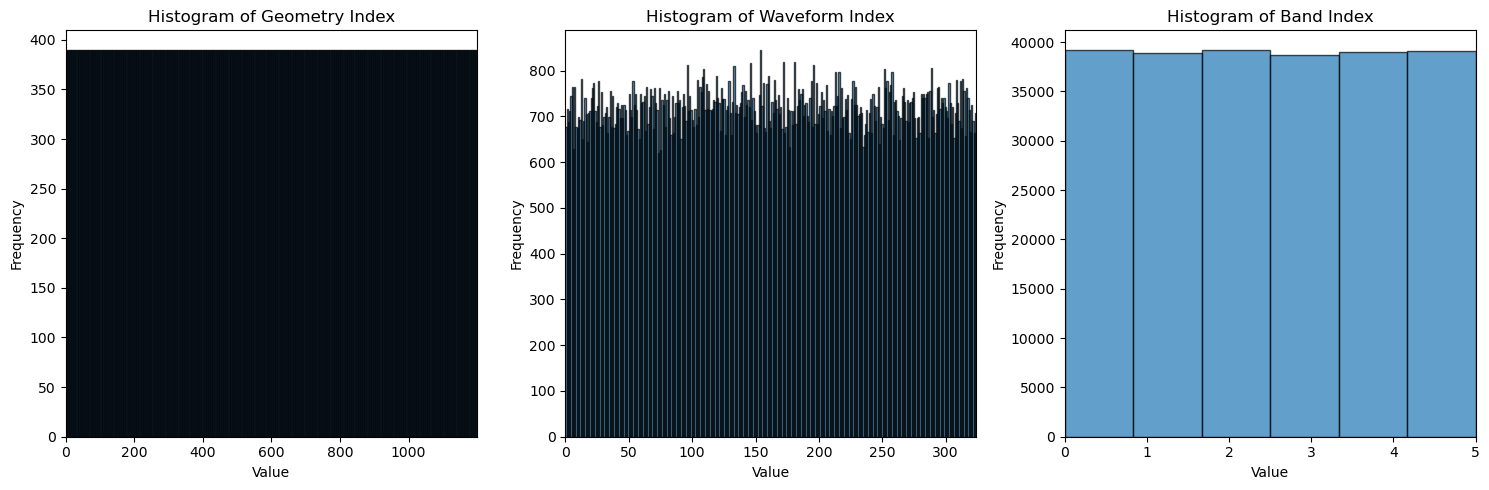

Shape of reduced_indices: (234000, 3)
Data type: int32


In [10]:
dataset_path = 'set_br_1200n_reduced_wv5_b2'
reduced_indices = torch.load(os.path.join('data',dataset_path, "reduced_indices.pt"))

# Convert (g, w, b) to numpy for easier plotting
reduced_indices_np = np.array(reduced_indices)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First number histogram (geometry index)
axes[0].hist(reduced_indices_np[:, 0], bins=600, alpha=0.7, edgecolor='black')
axes[0].set_title('Histogram of Geometry Index')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 1199)

# Second number histogram (waveform index)
axes[1].hist(reduced_indices_np[:, 1], bins=325, alpha=0.7, edgecolor='black')
axes[1].set_title('Histogram of Waveform Index')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 324)

# Third number histogram (band index)
axes[2].hist(reduced_indices_np[:, 2], bins=6, alpha=0.7, edgecolor='black')
axes[2].set_title('Histogram of Band Index')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].set_xlim(0, 5)

plt.tight_layout()
plt.show()

print(f"Shape of reduced_indices: {reduced_indices_np.shape}")
print(f"Data type: {reduced_indices_np.dtype}")
